In [1]:
using TensorBalancing
using BenchmarkTools
using JuMP
using Clp
using MNIST
import Images

ArrayFire v3.5.1 (CUDA, 64-bit Linux, build 0a675e8)
Platform: CUDA Toolkit 8, Driver: 390.30
[0] GeForce GTX 970, 4040 MB, CUDA Compute 5.2


In [2]:
type OptimalTransport
    metric::Array{Float64, 2}
    λ::Float64
    src::Array{Float64, 1}
    dest::Array{Float64 ,1}
    
    function OptimalTransport(metric, λ, src, dest)
        if sum(src) == sum(dest)
            return new(metric, λ, src, dest)
        else
            return new(metric, λ, src, dest ./ sum(dest) .* sum(src))
        end
    end
end

type Coordθ
    val::Array{Float64, 2}
end

type Coordη
    val::Array{Float64, 2}
end

In [3]:
function calcθ(ot::OptimalTransport)
    M = ot.metric
    λ = ot.λ
    m, n = size(M)
    θ = zeros(m, n)
    θ[1,1] = -λ*M[1,1]
    θ[1,2:end] = -λ*(M[1,2:end] - M[1,1:end-1])
    θ[2:end,1] = -λ*(M[2:end,1] - M[1:end-1,1])
    θ[2:end,2:end] = -λ*(M[2:end,2:end]-M[1:end-1,2:end]-M[2:end,1:end-1]+M[1:end-1,1:end-1])
    Coordθ(θ)
end

function calcη(θ::Coordθ)
    calcη(θtoP(θ))
end

function calcη(X::Array{Float64, 2})
    cumsum(cumsum(X[end:-1:1,:],1)[:,end:-1:1],2)[end:-1:1,end:-1:1]
end

calcη(ot::OptimalTransport) = calcη(calcK(ot))

function θtoP(θ::Coordθ)
    exp.(cumsum(cumsum(θ.val,1),2))
end

function cumsum_rev(v)
    reverse(cumsum(reverse(v)))
end

cumsum_rev (generic function with 1 method)

In [4]:
function calcK(ot::OptimalTransport)
    exp.(-ot.λ * ot.metric)
end

function solver_A(ot::OptimalTransport)
    K = calcK(ot)
    r, c = TensorBalancing.skBalancing(K, ot.src, ot.dest, 1.0e-6)
    K .* r .* c'
end

solver_A (generic function with 1 method)

In [5]:
function lbfgs_θ(ot::OptimalTransport, ϵ=1.0e-9, max_iter=65535; log_norm=false, only_x=false)
    M, N = size(ot.metric)
    θ = -ot.λ * ot.metric
    _θ = copy(θ)

    _g! = function(grad, x)
        #@show x
        _θ .= θ .+ x[1:N]'
        _θ[2:end,:] .+= x[N+1:end]
        P = exp.(_θ)
        grad .= vcat(sum(P,1)'-ot.dest, (sum(P,2) - ot.src)[2:end])[:,1]
    end
    g! = !log_norm ? _g! : 
        function(grad, x)
            _g!(grad, x)
            @printf "norm=%.18f\n" norm(grad)*(issym?sqrt(2):1)
            flush(STDOUT)
        end

    grad = zeros(M+N-1)
    grad_p = copy(grad)
    sbuf = []
    ybuf = []

    function tloop(g, ss, ys)
        p = -g
        local m = length(ss)
        if (m == 0) return p end
        alphas = zeros(m)
        for i = m:-1:1
            alphas[i] = (ss[i]' * p) / (ss[i]' * ys[i])
            p .-= alphas[i]*ys[i]
        end
        p *= ((ss[end])' * ys[end]) / ((ys[end])' * ys[end])
        for i=1:m
            beta = (ys[i]' * p) / (ss[i]' * ys[i])
            p += (alphas[i]-beta)ss[i]
        end
        return p
    end

    # initialize
    #x = -log.(vcat(sum(calcK(ot), 2), sum(calcK(ot), 1)[2:end])) ./ 2
    x = zeros(M+N-1)
    r, c = TensorBalancing.skBalancing(calcK(ot), ot.src, ot.dest, 1.0e1)
    x[1:N] = log.(c)
    x[N+1:end] = log.(r[2:end])
    x[1] += log(r[1])
    

    m=10
    k=1
    g!(grad, x)
    while norm(grad) > ϵ && k <= max_iter
        p = tloop(grad, sbuf, ybuf)
        #@show norm(grad)
        x += p
        grad_p .= grad
        g!(grad, x)
        if k > m
            sbuf = sbuf[2:end]
            ybuf = ybuf[2:end]
        end
        push!(sbuf, p)
        push!(ybuf, grad - grad_p)
        k += 1
    end
    if only_x
        return x
    end
    _θ = θ .+ x[1:N]'
    _θ[2:end,:] .+= x[N+1:end]
    P = exp.(_θ)
end

function solver_B(ot::OptimalTransport)
    K = calcK(ot)
    lbfgs_θ(ot, 1.0e-6)
end

solver_B (generic function with 1 method)

In [6]:
function solver_C(ot::OptimalTransport)
    M, N = size(ot.metric)
    m = Model(solver = ClpSolver())
    @variable(m, x[1:M,1:N] >= 0)
    @objective(m, Min, sum(x .* ot.metric))
    @constraint(m, x * ones(N) .== ot.src)
    @constraint(m, x' * ones(N) .== ot.dest)
    stat = solve(m)
    getvalue(x)
end

solver_C (generic function with 1 method)

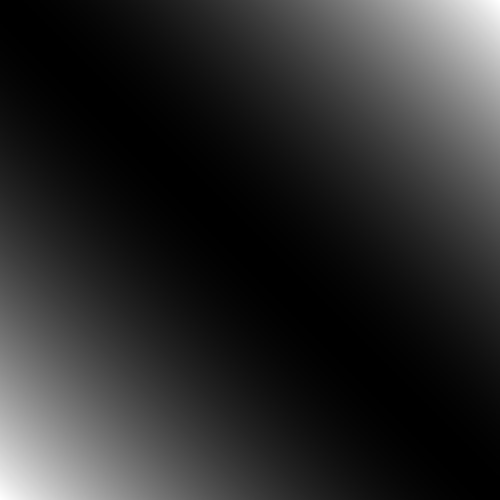

In [7]:
N = 500
xs = linspace(0, 1, N)
M = (xs' .- xs).^2
ot = OptimalTransport(M, 0.01, linspace(0,1,N), linspace(1,0,N))
Images.colorview(Images.Gray, M)

In [8]:
@belapsed solver_A(ot)

0.003498508

In [9]:
@belapsed solver_B(ot)

0.143015479

In [10]:
@belapsed solver_C(ot)

3.812688552

In [11]:
x_train, _ = traindata();

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:70
 [2] Array(::Type{Float64}, ::Int64, ::Int64) at ./deprecated.jl:57
 [3] traindata() at /home/koki/.pyenv/versions/miniconda3-latest/share/julia/site/v0.6/MNIST/src/MNIST.jl:88
 [4] include_string(::String, ::String) at ./loading.jl:522
 [5] include_string(::Module, ::String, ::String) at /home/koki/.pyenv/versions/miniconda3-latest/share/julia/site/v0.6/Compat/src/Compat.jl:174
 [6] execute_request(::ZMQ.Socket, ::IJulia.Msg) at /home/koki/.pyenv/versions/miniconda3-latest/share/julia/site/v0.6/IJulia/src/execute_request.jl:154
 [7] (::Compat.#inner#16{Array{Any,1},IJulia.#execute_request,Tuple{ZMQ.Socket,IJulia.Msg}})() at /home/koki/.pyenv/versions/miniconda3-latest/share/julia/site/v0.6/Compat/src/Compat.jl:496
 [8] eventloop(::ZMQ.Socket) at /home/koki/.pyenv/versions/miniconda3-latest/share/julia/site/v0.6/IJulia/src/eventloop.jl:8
 [9] (::IJulia.##14#17)() at ./task.jl:335
while loading In[11], in expression star

In [12]:
xs = [[x, y] for x in linspace(0, 1, 28), y in linspace(0, 1, 28)][:]
M = zeros(length(xs), length(xs))
for i = 1:length(xs), j = 1:length(xs)
    M[i,j] = norm(xs[i] - xs[j])
end
ot = OptimalTransport(M, 500, x_train[:,1], x_train[:,2]);

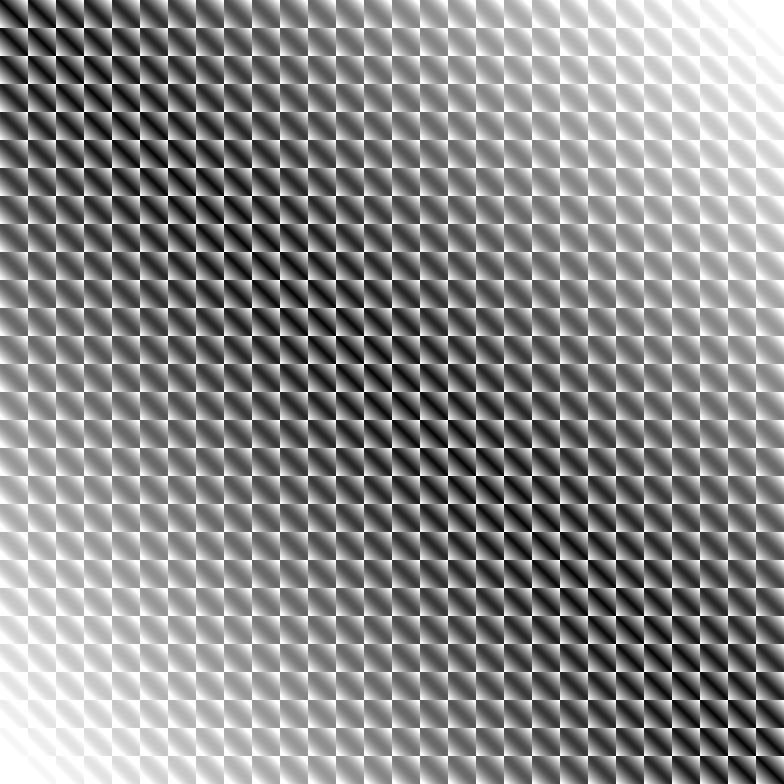

In [13]:
Images.colorview(Images.Gray, M)

  9.000887 seconds (124.73 k allocations: 23.087 GiB, 15.19% gc time)


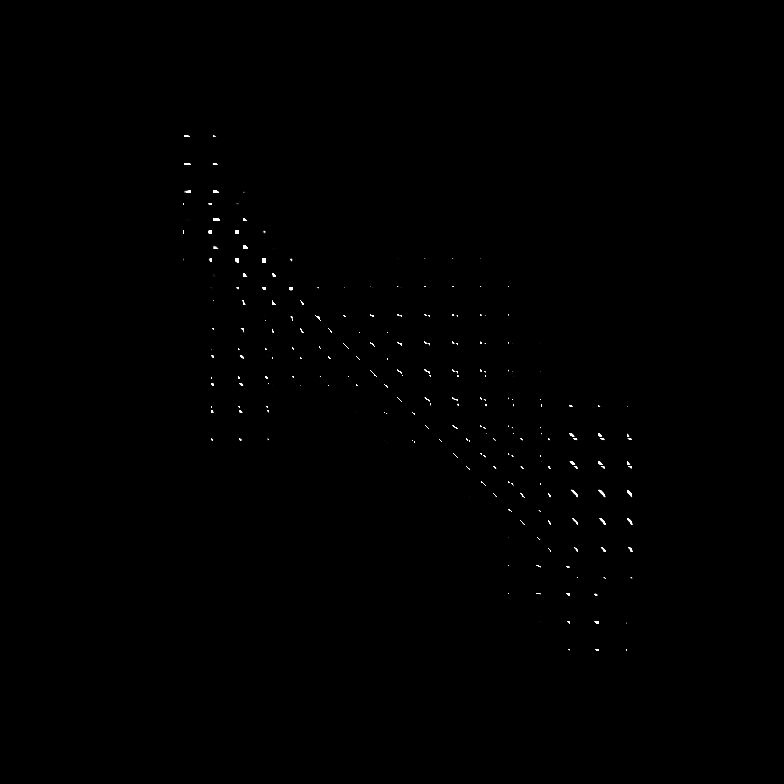

In [14]:
@time Images.colorview(Images.Gray,solver_A(ot))

  3.068716 seconds (117.21 k allocations: 7.216 GiB, 11.23% gc time)


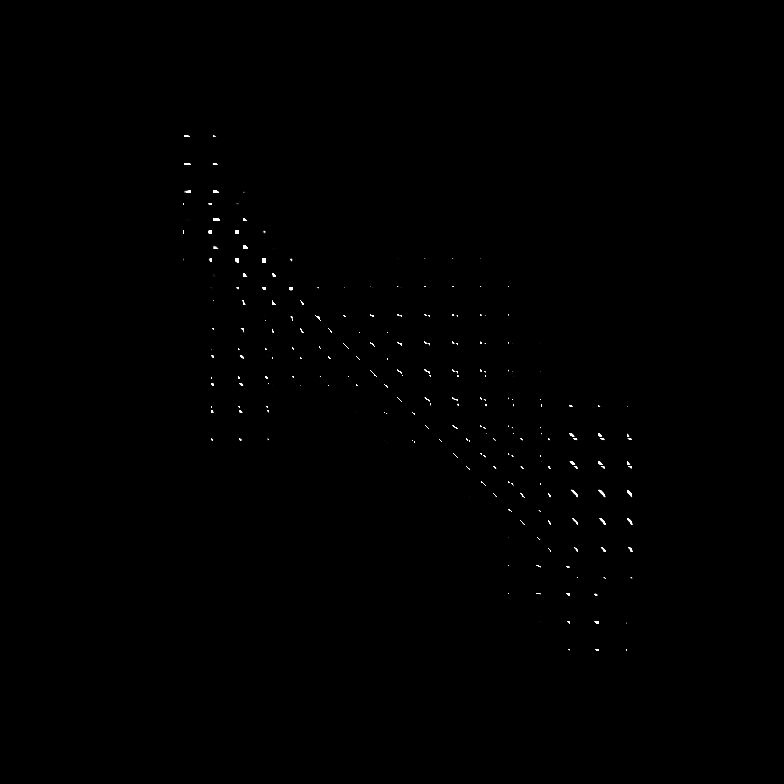

In [15]:
@time Images.colorview(Images.Gray,solver_B(ot))

  2.153754 seconds (13.54 M allocations: 1.010 GiB, 45.88% gc time)


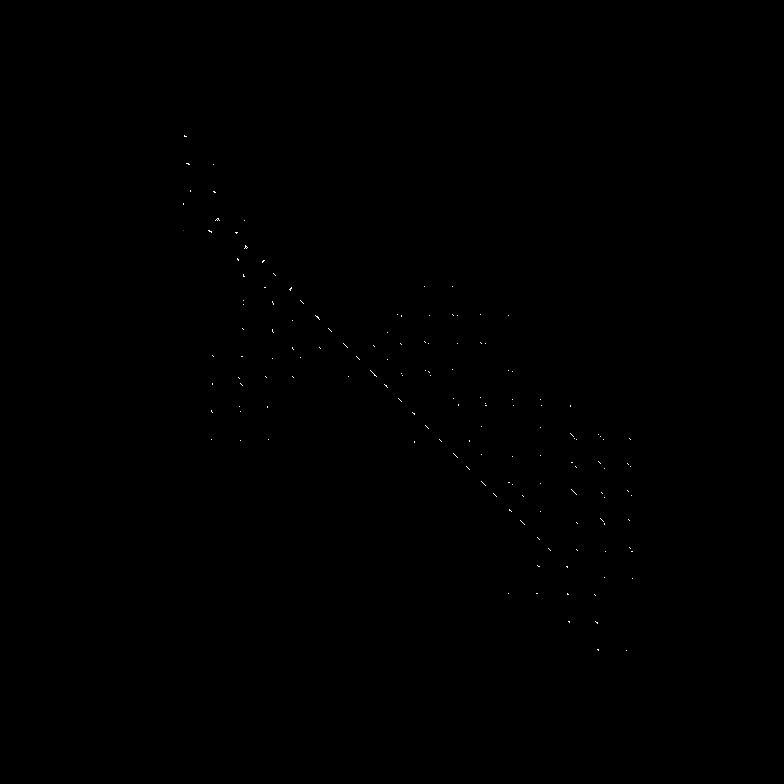

In [16]:
@time Images.colorview(Images.Gray,solver_C(ot))

In [17]:
xs = [[x, y] for x in linspace(0, 1, 28), y in linspace(0, 1, 28)][:]
M = zeros(length(xs), length(xs))
for i = 1:length(xs), j = 1:length(xs)
    M[i,j] = norm(xs[i] - xs[j])
end
ot = OptimalTransport(M, 5000, x_train[:,1], x_train[:,2]);

  0.013692 seconds (116 allocations: 23.548 MiB)


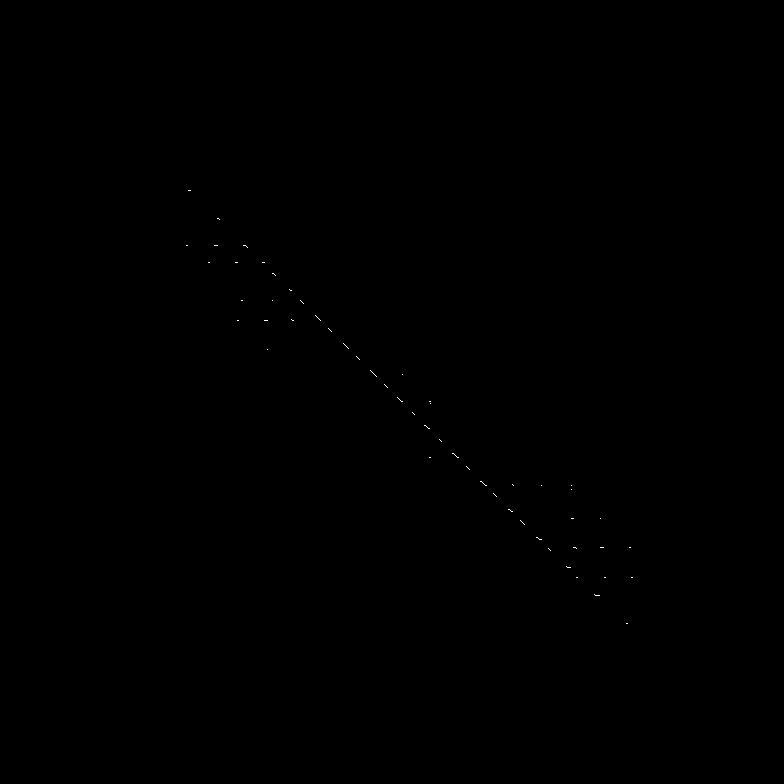

In [18]:
@time Images.colorview(Images.Gray,solver_A(ot))

  0.037226 seconds (395 allocations: 61.200 MiB)


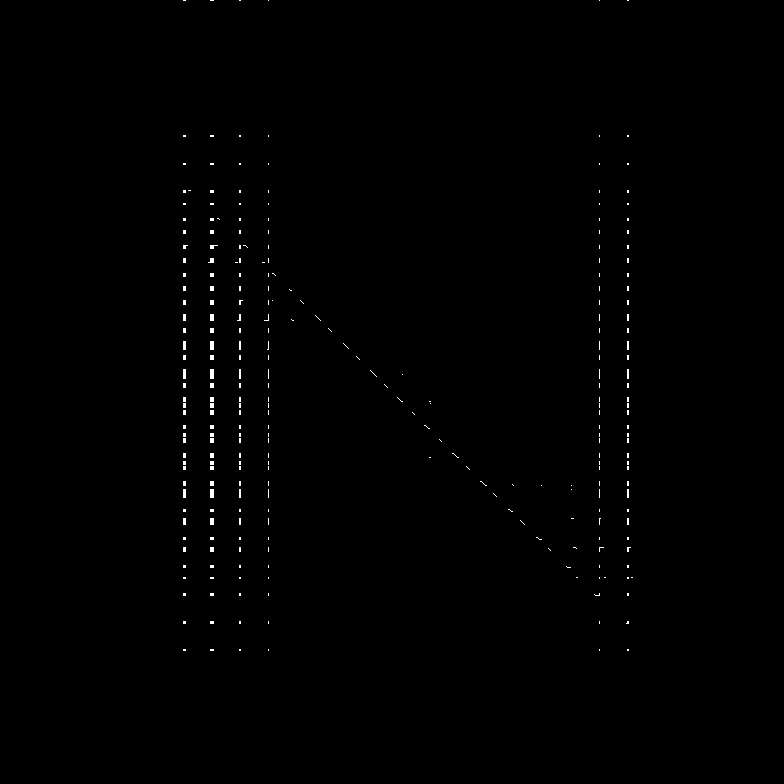

In [19]:
@time Images.colorview(Images.Gray,solver_B(ot))

  1.713267 seconds (13.54 M allocations: 1.033 GiB, 31.16% gc time)


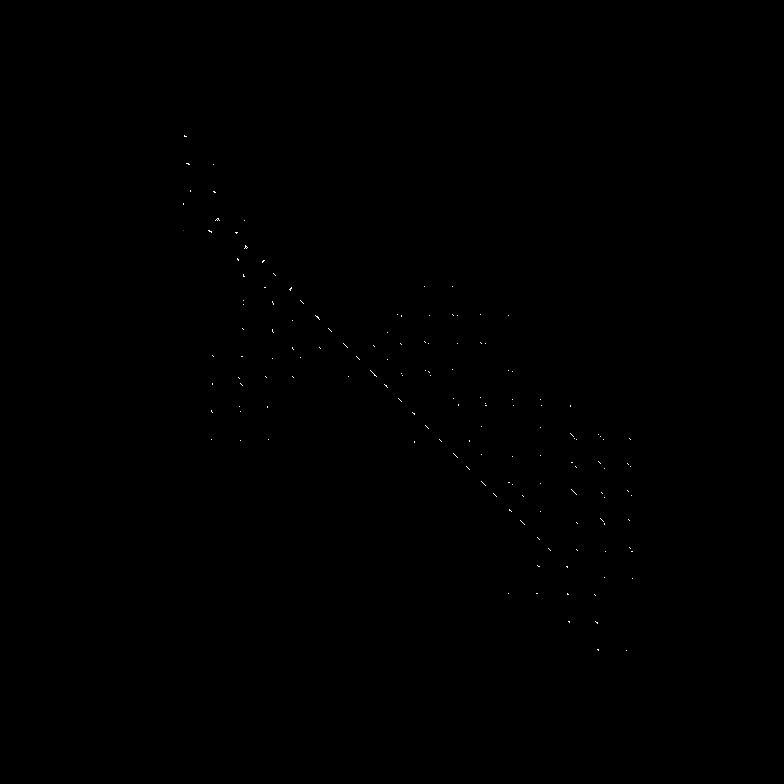

In [20]:
@time Images.colorview(Images.Gray,solver_C(ot))